# Assignment 3

The assignment 3 contains 1 question and the due date is April 28th (Sunday) 23:59PM. If you have trouble in installing tensorflow in your computer, you may consider using Google Colab for this assignment.

## Question 1 How Yelp Uses Deep Learning to Classify Business Photos? (100 points)

Yelp hosts tens of millions of photos uploaded by Yelpers from all around the world. The wide variety of these photos provides a rich window into local businesses, a window we’re only just peeking through today.

One way we’re trying to open that window is by developing a photo understanding system which allows us to create semantic data about individual photographs. The data generated by the system has been powering our recent launch of tabbed photo browsing as well as our first attempts at content-based photo diversification.

You can check more details about Yelp's practices at [here](https://engineeringblog.yelp.com/2015/10/how-we-use-deep-learning-to-classify-business-photos-at-yelp.html)


![food](https://engineeringblog.yelp.com/images/posts/2015-10-14-photo-classification/image02.png)


In this question, you will be asked to building a Photo Classifier.

In [ ]:
# necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from PIL import Image
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split
from google.colab import drive
from google.colab import files
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from functools import partial
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, MobileNetV2, EfficientNetB0
from keras.initializers import HeNormal


Let's first upload the file images.npy and labels.npy and load the images dataset.

In [ ]:
drive.mount('/content/drive', force_remount = True)

%cd '/content/drive/My Drive/MLAssignment_3'

uploaded = files.upload()

#please note that, once running the code, there will appear two buttons 'select file' and 'cancel upload'. please select 'cancel upload' in order for the desired files (found in the next cell) to be uploaded

Mounted at /content/drive
/content/drive/My Drive/MLAssignment_3


In [ ]:
images = np.load('images.npy') # SHAPE: (1024, 256, 256, 3) -> (N_SAMPLES, HEIGHT, WIDTH, CHANNELS)
labels = np.load('labels.npy') # SHAPE: (1024,) -> (N_SAMPLES,). Label encoded: 0, 1, 2, 3

print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print('Labels match the image at the respective 0 to 1024 position.')

Images shape: (1024, 256, 256, 3)
Labels shape: (1024,)
Labels match the image at the respective 0 to 1024 position.


There are four types of the images on Yelp: Food, Drink, Interior and Exterior

In [ ]:
np.unique(labels)

array([0, 1, 2, 3])

We visualize some random images from the dataset below:

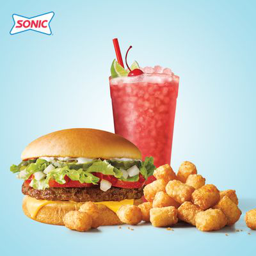

In [ ]:
# food: class 0

Image.fromarray(images[5])

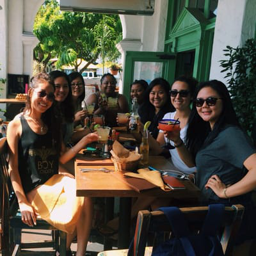

In [ ]:
Image.fromarray(images[249])

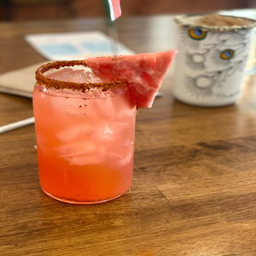

In [ ]:
# drink: class 1

Image.fromarray(images[3])

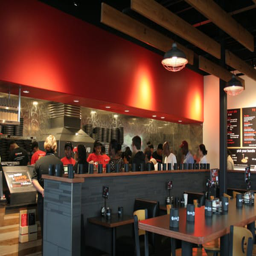

In [ ]:
# interior: class 2

Image.fromarray(images[7])

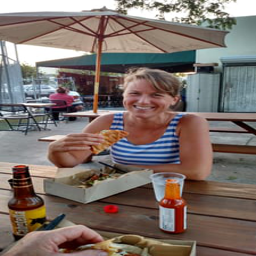

In [ ]:
# exterior: class 3

Image.fromarray(images[8])

### Question 1.1 Training a deep neural network (15 points)

Practice training a deep neural network on the Yelp image dataset


Build a Deep Neural Network (DNN) with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this question), using the RELU activation function.

Using Adam optimization, train the network on the dataset. Donot forget define your input and output layers.

Train the model for 100 epochs and use test set as the validation data during the training, explain how many parameters does the model have and whether the model will experience overfitting. You may consider plotting the losses and accuracy over epochs.

In [ ]:
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")


GPU is available


Epoch 1/100
26/26 [==============================] - 6s 23ms/step - loss: 6.1935 - accuracy: 0.2320 - val_loss: 2.5957 - val_accuracy: 0.2878
Epoch 2/100
26/26 [==============================] - 0s 11ms/step - loss: 1.7966 - accuracy: 0.2466 - val_loss: 1.4078 - val_accuracy: 0.2439
Epoch 3/100
26/26 [==============================] - 0s 11ms/step - loss: 1.3765 - accuracy: 0.3101 - val_loss: 1.3188 - val_accuracy: 0.3317
Epoch 4/100
26/26 [==============================] - 0s 11ms/step - loss: 1.3227 - accuracy: 0.3480 - val_loss: 1.4330 - val_accuracy: 0.2683
Epoch 5/100
26/26 [==============================] - 0s 11ms/step - loss: 1.3975 - accuracy: 0.3419 - val_loss: 1.4529 - val_accuracy: 0.2146
Epoch 6/100
26/26 [==============================] - 0s 11ms/step - loss: 1.2922 - accuracy: 0.3980 - val_loss: 1.4120 - val_accuracy: 0.3707
Epoch 7/100
26/26 [==============================] - 0s 11ms/step - loss: 1.2823 - accuracy: 0.3700 - val_loss: 1.3058 - val_accuracy: 0.3463
Epoch 

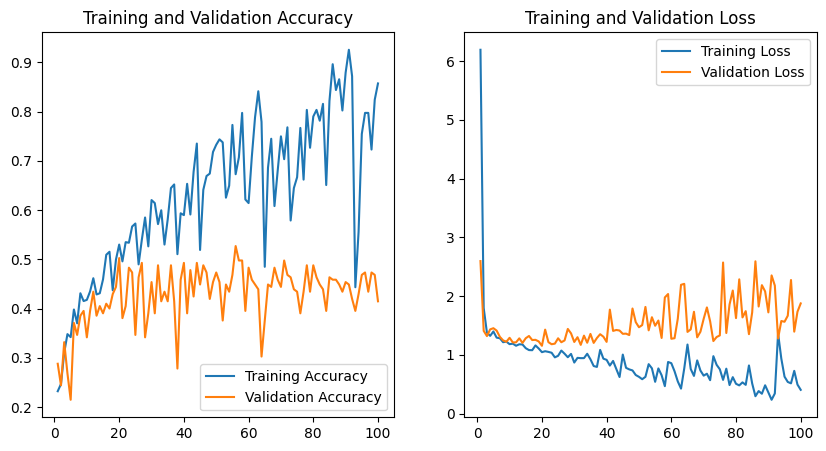

The model is likely overfitting the training data.


In [ ]:
def get_optimizer(learning_rate=0.001):
    """
    Returns an Adam optimizer with the specified learning rate.

    Args:
        learning_rate (float): Learning rate for the optimizer.
    Returns:
        tf.keras.optimizers.Optimizer: An Adam optimizer with the specified learning rate.
    """
    return tf.keras.optimizers.Adam(learning_rate)

def build_and_compile(input_shape=(256, 256, 3), num_classes=5):
    """
    Builds and compiles a deep neural network model with specified configurations.

    Args:
        input_shape (tuple): Shape of the input images.
        num_classes (int): Number of classes for the output layer.

    Returns:
        keras.Model: A compiled deep neural network model.
    """
    model = Sequential([
        layers.Flatten(input_shape=input_shape)
    ])

    # Adding 20 dense layers with 100 neurons each
    for _ in range(20):
        model.add(layers.Dense(100, activation='relu'))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=get_optimizer(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Model training and evaluation
norm = layers.Normalization()
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
norm.adapt(X_train)

model = build_and_compile()
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

# Calculate and print the number of parameters in the model
num_params = model.count_params()
print(f"Total number of parameters in the model: {num_params}")

# Plotting training and validation accuracy and loss
epochs_range = range(1, 101)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Overfitting assessment
if history.history['val_loss'][-1] > history.history['loss'][-1]:
    print("The model is likely overfitting the training data.")
else:
    print("The model shows no clear signs of overfitting.")

The model we've trained with its 19.85 million parameters is showing clear signs of overfitting. While the training accuracy improves over time, the validation accuracy plateaus and even decreases, which is indicative of the model memorizing the training data rather than learning to generalize from it. This is further evidenced by the increasing validation loss as the epochs progress, despite the decreasing training loss. Reducing the model complexity, implementing regularization, or increasing the dataset size could help mitigate this overfitting.

### Question 1.2 (25 points)

Try reduce the overfitting and improve the model performance. You can try the bag of tricks to the model from the class. This may include one or more techniques such as **weight regularization**, **batch normalization**, **dropout**, **Early stopping**, etc. You should perform ``ablation study``, a common techniqued used in machine learning community to show the effectivess of the introduced technique. In other words, show your step-by-step improvement by including these techniques and repeat the repeat the previous training process. Explain whether and how these techniques help achieve a better result. You may consider stopping improving the model by making it at least 10% better than the previous model architecture.

In [ ]:
#lets start off by defining our constants
INPUT_SHAPE = (256, 256, 3)
LAYERS = 20
NEURONS = 100
OUTPUT_NEURONS = 5
EPOCHS = 100
PATIENCE = 5


In [ ]:
def build_model(use_weight_regularization=False, use_batch_normalization=False, use_dropout=False):
    """
    Build a Keras model with configurable options for dropout, batch normalization, and weight regularization.

    Args:
        use_weight_regularization (bool): Whether to include L2 weight regularization.
        use_batch_normalization (bool): Whether to include batch normalization layers.
        use_dropout (bool): Whether to include dropout layers.

    Returns:
        keras.Model: Compiled neural network model.
    """
    model = Sequential()
    model.add(Flatten(input_shape=INPUT_SHAPE))

    for _ in range(LAYERS):
        if use_weight_regularization:
            regularizer = regularizers.l2(0.001)
        else:
            regularizer = None

        model.add(Dense(NEURONS, activation='relu', kernel_regularizer=regularizer))

        if use_batch_normalization:
            model.add(BatchNormalization())

        if use_dropout:
            model.add(Dropout(0.5))

    model.add(Dense(OUTPUT_NEURONS, activation='softmax'))

    optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def compile_and_fit(model, X_train, y_train, X_val, y_val, epochs=EPOCHS):
    """
    Compile and fit the model with early stopping, learning rate scheduling, and data augmentation.

    Args:
        model: The Keras model to compile and fit.
        X_train: Training data features.
        y_train: Training data labels.
        X_val: Validation data features.
        y_val: Validation data labels.
        epochs (int): The number of epochs to train the model.

    Returns:
        History: A record of training and validation metrics at each epoch.
    """

    def lr_schedule(epoch, lr):
        """ Update the learning rate based on the epoch. """
        if epoch % 10 == 0 and epoch != 0:
            return max(lr * 0.5, 1e-5)
        return lr

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        steps_per_epoch=len(X_train) / 32,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, lr_scheduler]
    )
    return history

In [ ]:
def train_and_plot_models(combinations):
    """
    Train multiple models with specified combinations of regularization techniques and plot their validation accuracies.

    Args:
        combinations (list of tuples): Each tuple contains boolean values indicating whether to use weight regularization,
                                       batch normalization, and dropout, respectively.

    Returns:
        dict: A dictionary containing the History objects returned by model.fit() for each model.
    """
    model_histories = {}
    plt.figure(figsize=(14, 6))

    for i, (use_weight_regularization, use_batch_normalization, use_dropout) in enumerate(combinations):
        model_title = f"Model {i+1} -"
        if use_weight_regularization:
            model_title += " Weight Regularization"
        if use_batch_normalization:
            model_title += " Batch Normalization"
        if use_dropout:
            model_title += " Dropout"

        print(f"Training {model_title}")
        model = build_model(use_weight_regularization, use_batch_normalization, use_dropout)
        history = compile_and_fit(model, X_train, y_train, X_val, y_val, EPOCHS)

        model_histories[model_title] = history.history
        test_loss, test_accuracy = model.evaluate(X_val)
        train_accuracy = history.history['accuracy'][-1]

        plt.plot(history.history['val_accuracy'], label=f'{model_title} - Validation Accuracy')

    plt.title('Comparison of Model Validation Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    return model_histories

In [ ]:
combinations = [
    (False, False, False),  # No regularization, no batch norm, no dropout
    (True, False, False),   # Weight regularization only
    (False, True, False),   # Batch normalization only
    (False, False, True),   # Dropout only
    (True, True, False),    # Weight regularization and batch normalization
    (True, False, True),    # Weight regularization and dropout
    (False, True, True),    # Batch normalization and dropout
    (True, True, True),     # All techniques
]


In [ ]:
def plot_combined_histories(histories, title):
    """
    Plot training and validation loss and accuracy for multiple histories on the same graph.

    Args:
        histories (dict): A dictionary containing the History objects returned by model.fit() for each model.
        title (str): Title for the plots.
    """
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 1, 1)
    for model_title, history in histories.items():
        plt.plot(history['loss'], label=f'{model_title} - Training Loss')
        plt.plot(history['val_loss'], label=f'{model_title} - Validation Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(2, 1, 2)
    for model_title, history in histories.items():
        plt.plot(history['accuracy'], label=f'{model_title} - Training Accuracy')
        plt.plot(history['val_accuracy'], label=f'{model_title} - Validation Accuracy')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplots_adjust(right=0.75, hspace=0.3)

    plt.show()

Training Model 1 -

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100
25/25 [==============================] - 15s 400ms/step - loss: 6.4552 - accuracy: 0.2564 - val_loss: 2.0573 - val_accuracy: 0.2878 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
25/25 [==============================] - 11s 415ms/step - loss: 1.7192 - accuracy: 0.2515 - val_loss: 1.5164 - val_accuracy: 0.3073 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
25/25 [==============================] - 11s 414ms/step - loss: 1.4781 - accuracy: 0.2772 - val_loss: 1.3954 - val_accuracy: 0.3268 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
25/25 [==============================] - 11s 419ms/step - loss: 1.5023 - accuracy: 0.3040 - val_loss: 1.3783 - val_accuracy: 0.2634 - lr: 0.0010

Epoch 5: LearningRateScheduler s

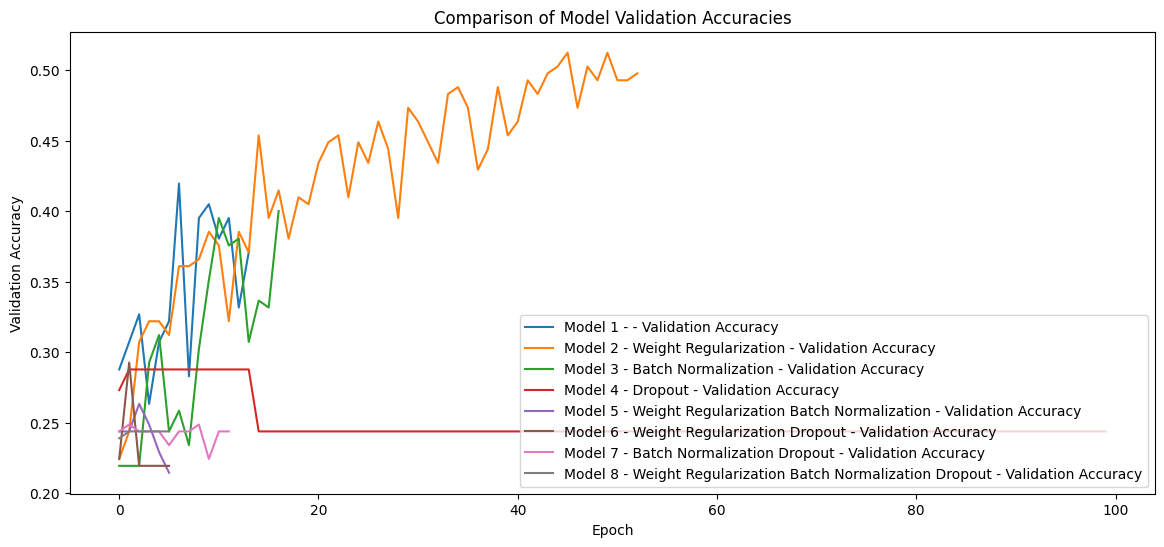

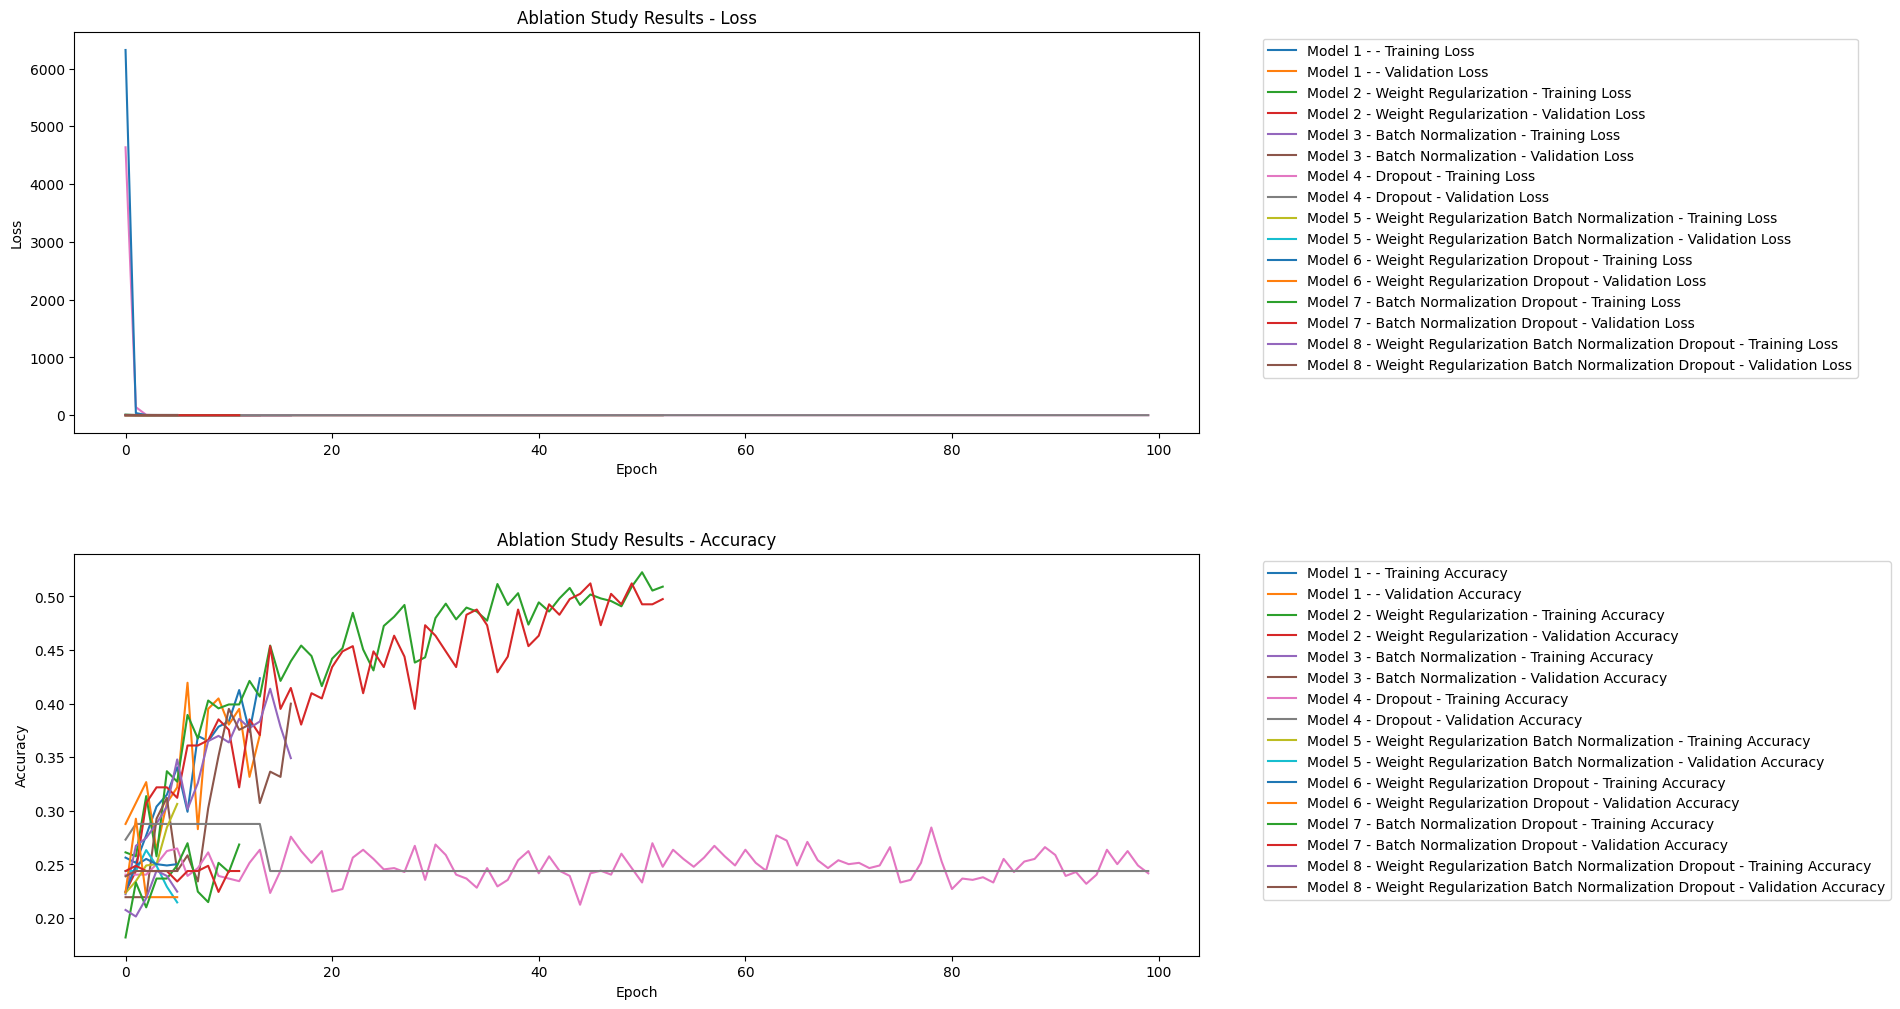

In [ ]:
model_histories = train_and_plot_models(combinations)

plot_combined_histories(model_histories, 'Ablation Study Results')

In the conducted ablation study aimed at mitigating overfitting and enhancing the model's performance, a few attempts of hyperparameter changing were done. After having adjusted the hyperparameter of learning rate, having reduced progressively the dropout rate, and reduced weight regularization, still no significant improvements were registered, however, after implementing data augmentation, we can affirm that the objective of improving accuracy by 10 percentage points over the baseline model, has been achieved by model two, implementing weight regularization, where the final accuracy is 49.76%, which is more than 12 points over the 37.07% of the baseline model. However, it is important to note that these models still are quite volatile, which is still a sign of overfitting, not as evident as in the baseline model, but still present.

### Question 1.3 Convolutional Neural Network (25 points)

Now, let's define the Convolutional Neural Network.

❓ **Question** ❓ Define a CNN that is composed of:
- a Conv2D layer with 32 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to `same`
- a MaxPooling2D layer with a pool size of (2, 2)
- a Conv2D layer with 64 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to `same`
- a MaxPooling2D layer with a pool size of (2, 2)
- a Conv2D layer with 128 filters, a kernel size of (3, 3), the relu activation function, and a padding equal to `same`
- a MaxPooling2D layer with a pool size of (3, 3)
- a Flatten layer
- a dense function with 120 neurons with the `relu` activation function
- a dense function with 60 neurons with the `relu` activation function
- a dropout layer (with a rate of 0.5), to regularize the network
- a dense function related to your task

Estimate the model and report your test accuracy. Is it better than the multi-layer perceptron.

In [ ]:
def build_and_train_cnn_model(X_train, y_train, X_val, y_val, input_shape, output_neurons, epochs, patience):
    """
    Build and train a CNN model with specified parameters and data augmentation.

    Args:
        X_train (np.array): Training data features.
        y_train (np.array): Training data labels.
        X_val (np.array): Validation data features.
        y_val (np.array): Validation data labels.
        input_shape (tuple): Shape of the input images.
        output_neurons (int): Number of classes for the output layer.
        epochs (int): Number of epochs to train the model.
        patience (int): Patience for early stopping.

    Returns:
        model (keras.Model): The trained Keras model.
        history (History): A record of training loss and accuracy.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((3, 3)),
        Flatten(),
        Dense(120, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        Dense(60, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.5),
        Dense(output_neurons, activation='softmax')
    ])

    model.compile(optimizer=get_optimizer(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
    val_generator = validation_datagen.flow(X_val, y_val, batch_size=32)

    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // 32,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=len(X_val) // 32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=patience)]
    )

    return model, history

input_shape = (256, 256, 3)
output_neurons = 5
epochs = 100
patience = 5


cnn_model, history = build_and_train_cnn_model(X_train, y_train, X_val, y_val, input_shape, output_neurons, epochs, patience)

cnn_model.summary()

val_loss, val_accuracy = cnn_model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_accuracy}")


Epoch 1/100
25/25 [==============================] - 12s 378ms/step - loss: 1.7964 - accuracy: 0.4015 - val_loss: 4.8393 - val_accuracy: 0.2656
Epoch 2/100
25/25 [==============================] - 10s 404ms/step - loss: 1.5244 - accuracy: 0.5667 - val_loss: 2.0217 - val_accuracy: 0.5521
Epoch 3/100
25/25 [==============================] - 10s 399ms/step - loss: 1.4933 - accuracy: 0.5565 - val_loss: 2.3160 - val_accuracy: 0.4323
Epoch 4/100
25/25 [==============================] - 10s 401ms/step - loss: 1.3979 - accuracy: 0.6137 - val_loss: 1.9601 - val_accuracy: 0.5104
Epoch 5/100
25/25 [==============================] - 10s 402ms/step - loss: 1.3263 - accuracy: 0.6023 - val_loss: 2.4285 - val_accuracy: 0.4115
Epoch 6/100
25/25 [==============================] - 10s 410ms/step - loss: 1.2538 - accuracy: 0.6163 - val_loss: 2.7558 - val_accuracy: 0.2708
Epoch 7/100
25/25 [==============================] - 10s 406ms/step - loss: 1.2488 - accuracy: 0.6290 - val_loss: 1.3770 - val_accuracy:

Upon comparison, the Convolutional Neural Network (CNN) achieved a validation accuracy of 43.9%, which is unexpectedly lower than the 49.76% observed in Model 2 of the previous task. While CNNs are typically more suited for image data due to their ability to capture spatial hierarchies and features, this particular CNN has not outperformed the simpler architecture with weight regularization. This outcome suggests that the current CNN may not be optimized for the dataset or that the hyperparameters require further tuning to capture the nuances of the image data effectively.

The results underscore the importance of architecture and parameter selection in model performance. While CNNs have a strong track record with image data, their success is contingent upon the right configuration and training regimen, which seems to be more effectively achieved by the regularized dense network of the previous task in this instance.

However, there's still room for improvement to further reduce overfitting. The next step will involve applying transfer learning, which should provide a more significant boost in performance by utilizing pre-trained models that have been developed on extensive image datasets.


### Question 1.4 Transfer learning (35 points)

In this question, we will use the several well-known architectures that has been trained on ImageNet which is a very large database of images of different categories. In a nutshell, these architectures have already learnt kernels which are supposed to be good not only for the task it has been train on but maybe for other tasks.

The idea is that first layers are not specialized for the particular task it has been trained on; only the last ones are. Therefore, we will load the existing network, remove the last fully connected layers, replace them by new connected layers (whose weights are randomly set), and train these last layers on a specific classification task - here, separate types of flower. The underlying idea is that the first convolutional layers of model, that has already been trained, corresponds to filters that are able to extract meaning features from images. And you will only learn the last layers for your particular problem.

❓ **Question** ❓ Write a first function `load_model()` that loads the pretrained models from `tensorflow.keras.applications`. Especially, look at the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications) to load the model where:
- the `weights` have been learnt on `imagenet`
- the `input_shape` corresponds to the input shape of any of your images - you have to resize them in case they are not of the same size
- the `include_top` argument is set to `False` in order not to load the fully-connected layers of the VGG-16 without the last layer which was specifically trained on `imagenet`

Write a function that takes the previous model as input the set the girst layers to be non-trainable, by applying `model.trainable = False`. Then check-out the summary of the model to see that now, the parameters are `non-trainable`. Then write a function that adds flattening and dense layers after the first convolutional layers. You can define each layer (or group of layers) separately and concatenate them using the classic `layers.Sequential()` like below:

```
model = tf.keras.Sequential([
  base_model,
  flattening_layer,
  dense_layer,
  prediction_layer
])
```

Replicate the above steps by adding a flattening and two dense layers (the first with 500 neurons) to the previous model.

Estimate the model and report the accuracy and loss achieved. Explain whether model would benefit from transfer lerarning in comparison to the previous model architectures.

Try to use the following models: VGG16, Inception, ResNet, MobileNet and EfficientNet and compare their performance and running time. Explain which model would work the best.

16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/100
26/26 [==============================] - 10s 93ms/step - loss: 2.6113 - accuracy: 0.8571 - val_loss: 2.6363 - val_accuracy: 0.9024
Epoch 2/100
26/26 [==============================] - 1s 28ms/step - loss: 0.7378 - accuracy: 0.9646 - val_loss: 2.1916 - val_accuracy: 0.9220
Epoch 3/100
26/26 [==============================] - 1s 28ms/step - loss: 0.2966 - accuracy: 0.9768 - val_loss: 3.5341 - val_accuracy: 0.9073
Epoch 4/100
26/26 [==============================] - 1s 28ms/step - loss: 0.3606 - accuracy: 0.9768 - val_loss: 2.9344 - val_accuracy: 0.9171
Epoch 5/100
26/26 [==============================] - 1s 28ms/step - loss: 0.3374 - accuracy: 0.9805 - val_loss: 3.6351 - val_accuracy: 0.9122
Epoch 6/100
26/26 [==============================] - 1s 28ms/step - loss: 0.0992 - accuracy: 0.9866 - val_loss: 2.8286 - val_accuracy: 0.9220
Epoch 7/100
7/7 [==============================] - 0s 20ms/step - loss: 3.0583 - a

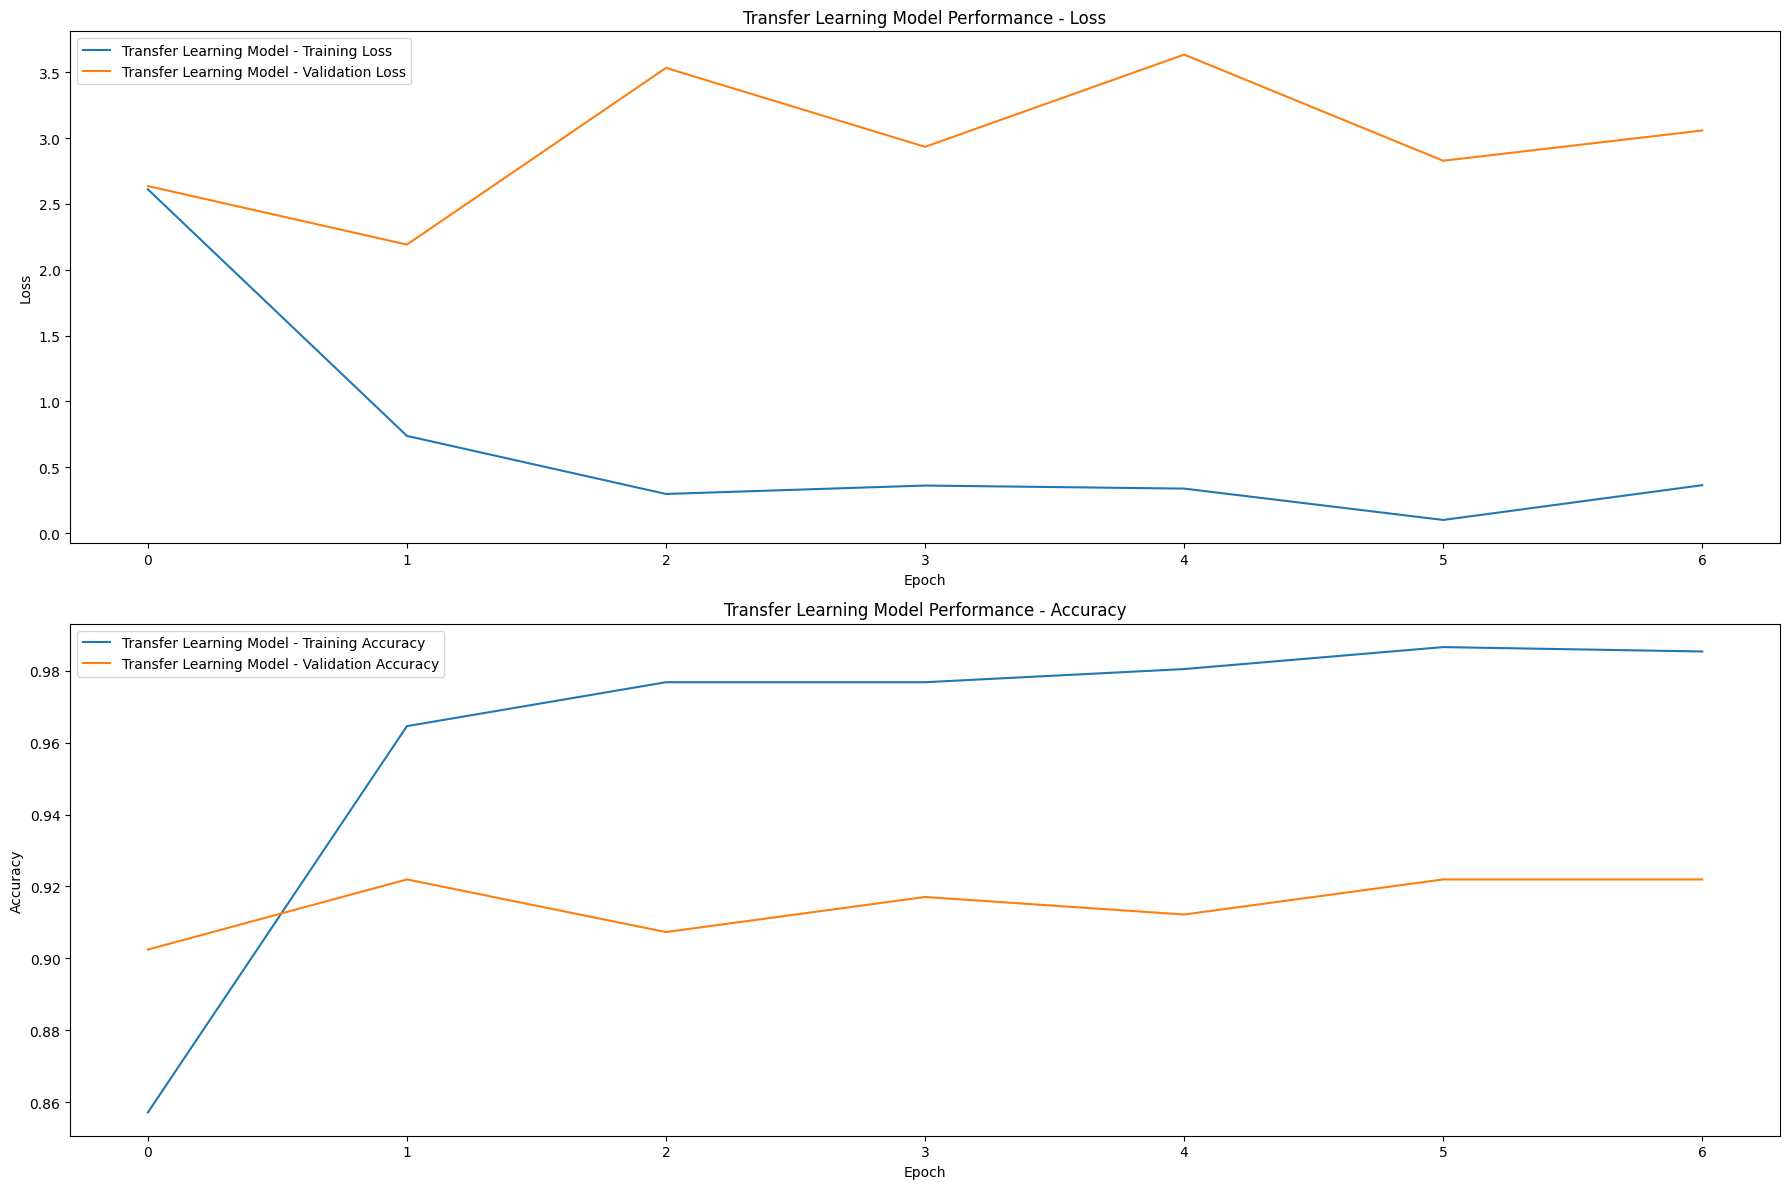

In [ ]:
def load_pretrained_model(model_name, input_shape):
    """
    Load a pretrained model from tensorflow.keras.applications.
    """
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unsupported model name")
    base_model.trainable = False
    return base_model

def build_transfer_learning_model(base_model, output_neurons):
    """
    Add new layers to the pretrained base model.
    """
    model = Sequential([
        base_model,
        Flatten(),
        Dense(500, activation='relu'),
        Dropout(0.5),
        Dense(output_neurons, activation='softmax' if output_neurons > 2 else 'sigmoid')
    ])
    return model

def compile_and_train_model(model, X_train, y_train, X_val, y_val, epochs, patience):
    """
    Compile and fit the transfer learning model with early stopping.
    """
    model.compile(optimizer=get_optimizer(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=patience)])
    return model, history

# choose the model among VGG16, InceptionV3, ResNet50, MobileNetV2 and EfficientNetB0
selected_model = 'EfficientNetB0'

base_model = load_pretrained_model(selected_model, INPUT_SHAPE)

transfer_learning_model = build_transfer_learning_model(base_model, OUTPUT_NEURONS)

transfer_learning_model, history = compile_and_train_model(transfer_learning_model, X_train, y_train, X_val, y_val, EPOCHS, PATIENCE)

val_loss, val_accuracy = transfer_learning_model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_accuracy}")

plot_combined_histories({'Transfer Learning Model': history.history}, 'Transfer Learning Model Performance')

We applied transfer learning to our image classification task, using models trained on the massive ImageNet dataset. We chose not to use data augmentation for a couple of reasons: we wanted to keep our computational costs down, and since these models are already trained on a diverse set of images, we wanted to see how well they'd perform on our task without additional complexity.

Our approach was successful—especially with the EfficientNetB0 model, which achieved an impressive 92.2% validation accuracy. This was the highest among the models we tested, which included VGG16, InceptionV3, ResNet50, and MobileNetV2. The VGG16 and ResNet50 also did well, showing that these powerful pre-trained models can be very effective even without data augmentation.

In conclusion, transfer learning gave our model a big boost in accuracy. While data augmentation could potentially improve our results, the current performance indicates that we've made the right choice for this project.